In [310]:
import pandas as pd
import numpy as np
import torch 
from fredapi import Fred
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import mlflow
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import os
from torch import optim
import torch.nn as nn

In [26]:
batch_size = 4
seq_length = 2
random_seed = 1
torch.manual_seed(random_seed)
log_interval = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
ml_client = MLClient.from_config(DefaultAzureCredential())

Found the config file in: .\config.json


In [4]:
uri = ml_client.workspaces.get("workspace").mlflow_tracking_uri
mlflow.set_tracking_uri(uri)

In [5]:
%%writefile time_series_config.yaml
FRED:
    CPIAUCSL:
        name: CPI
        log: true
        diff: true
    FEDFUNDS:
        name: fed_rate
        log: true
        diff: true
    UNRATE:
        name: Unemployment
        log: false
        diff: false

Overwriting time_series_config.yaml


In [311]:
path = "./params"
os.makedirs(path, exist_ok=True)

In [6]:
def get_fred_api_key(path):
    with open(path, 'r') as f:
        key = f.read()
        return key

    
def get_data_config(path):
    with open(path, 'r') as f:
        config = yaml.safe_load(f)
        return config
        
config_path = Path("./configs")

key = get_fred_api_key(config_path / "fred_key.txt")
fred = Fred(api_key=key)

configs = get_data_config(config_path / "time_series_config.yaml")
fred_data = configs["FRED"]

def get_data(data_dict):
    data = {fred_data[code].get('name'): fred.get_series_latest_release(code) for code in fred_data}
    df = pd.DataFrame(data)
    return df

data = get_data(fred_data)
print(data.shape)
data.tail()

(926, 3)


,CPI,fed_rate,Unemployment
2023-10-01,307.531,5.33,3.8
2023-11-01,308.024,5.33,3.7
2023-12-01,308.742,5.33,3.7
2024-01-01,309.685,5.33,3.7
2024-02-01,311.054,5.33,3.9


In [7]:
def difference_data(df):
    df['log_inflation_MoM'] =  np.log(df["CPI"]).diff()
    df['fed_rate_DIFF'] = np.log(df["fed_rate"]).diff()
    df['Unemployment_DIFF'] = df["Unemployment"].diff()
    return df.dropna()

data_diff = difference_data(data)
print(data_diff.tail())

                CPI  fed_rate  Unemployment  log_inflation_MoM  fed_rate_DIFF  \
2023-10-01  307.531      5.33           3.8           0.000790            0.0   
2023-11-01  308.024      5.33           3.7           0.001602            0.0   
2023-12-01  308.742      5.33           3.7           0.002328            0.0   
2024-01-01  309.685      5.33           3.7           0.003050            0.0   
2024-02-01  311.054      5.33           3.9           0.004411            0.0   

            Unemployment_DIFF  
2023-10-01                0.0  
2023-11-01               -0.1  
2023-12-01                0.0  
2024-01-01                0.0  
2024-02-01                0.2  


<Axes: >

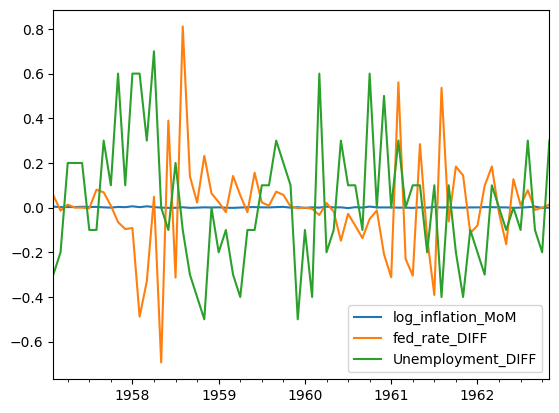

In [410]:
data_diff[["log_inflation_MoM", "fed_rate_DIFF", "Unemployment_DIFF"]].iloc[30:100].plot()

<Axes: >

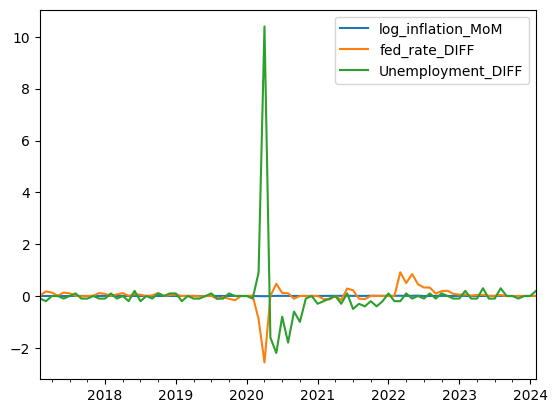

In [600]:
data_diff[["log_inflation_MoM", "fed_rate_DIFF", "Unemployment_DIFF"]].iloc[750:].plot()

In [605]:
data_diff.loc["2020-03-01"]

CPI                  258.150000
Unemployment           4.400000
fed_rate               0.650000
log_inflation_MoM     -0.004237
fed_rate_DIFF         -0.888208
Unemployment_DIFF      0.900000
Name: 2020-03-01 00:00:00, dtype: float64

In [8]:
cutoff = int(data_diff.shape[0]*0.75)
print(cutoff)
data_diff.iloc[cutoff-1]

626


CPI                  202.800000
fed_rate               5.250000
Unemployment           4.500000
log_inflation_MoM     -0.004919
fed_rate_DIFF          0.000000
Unemployment_DIFF     -0.200000
Name: 2006-09-01 00:00:00, dtype: float64

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

class MonetaryPolicyDataSet(torch.utils.data.Dataset):
    def __init__(self, train=True, train_end_year=None, seq_length=3):
        self.seq_length = seq_length
        
        configs = get_data_config(config_path / "time_series_config.yaml")
        self.data_dict = configs["FRED"]
        
        
        data = get_data(self.data_dict)
        self.data = difference_data(data)[["log_inflation_MoM", "fed_rate_DIFF", "Unemployment_DIFF"]]
        self.data = self.data[self.data.index != "2020-04-01"]
        
        if train:
            self.data = self.data.loc[:train_end_year]
            scaler.fit(self.data)
        else:
            # Create test set after the train_end_year
            self.data = self.data.loc[pd.to_datetime(train_end_year) + pd.DateOffset(months=1):]
        
        self.data = scaler.transform(self.data)
        # Convert to pytorch tensor
        self.data = torch.tensor(self.data)
        
        
    def __getitem__(self, t):
        return self.data[t: t + self.seq_length], self.data[t + self.seq_length]
    
    
    def __len__(self):
        return len(self.data) - self.seq_length

In [123]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def get_data_loaders(train_cutoff, seq_length):

    train_dataset = MonetaryPolicyDataSet(train=True, train_end_year=train_cutoff, seq_length = seq_length)
    test_dataset = MonetaryPolicyDataSet(train=False, train_end_year=train_cutoff, seq_length = seq_length)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_dataloader, test_dataloader 

train_dataloader, test_dataloader = get_data_loaders("2006-09-01", seq_length)

batch_id, (x, y) = next(enumerate(train_dataloader))
print(x, y)
print(x.size())

tensor([[[-1.1938,  4.2889,  1.0671],
         [-1.5645, -1.3737,  0.5391]],

        [[-1.5645, -1.3737,  0.5391],
         [-2.1849, -2.3870, -2.1014]],

        [[-2.1849, -2.3870, -2.1014],
         [-0.3269, -0.2745, -2.1014]],

        [[-0.3269, -0.2745, -2.1014],
         [-1.1942,  4.4035, -1.5733]]], dtype=torch.float64) tensor([[-2.1849, -2.3870, -2.1014],
        [-0.3269, -0.2745, -2.1014],
        [-1.1942,  4.4035, -1.5733],
        [-1.0704,  0.8132, -0.5171]], dtype=torch.float64)
torch.Size([4, 2, 3])


In [254]:
batch_id, (x, y) = next(enumerate(test_dataloader))
print(x)

tensor([[[-0.0044,  0.0000, -0.1000],
         [ 0.0005,  0.0000,  0.1000],
         [ 0.0054, -0.0019, -0.1000]],

        [[ 0.0005,  0.0000,  0.1000],
         [ 0.0054, -0.0019, -0.1000],
         [ 0.0017,  0.0019,  0.2000]],

        [[ 0.0054, -0.0019, -0.1000],
         [ 0.0017,  0.0019,  0.2000],
         [ 0.0039,  0.0019, -0.1000]],

        [[ 0.0017,  0.0019,  0.2000],
         [ 0.0039,  0.0019, -0.1000],
         [ 0.0052,  0.0000, -0.1000]]], dtype=torch.float64)


In [277]:
import torch.functional as F
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNModel, self).__init__()
        
        self.recurrent_layer = torch.nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = 1,
            batch_first = True,
            bidirectional = False
        )
        
        self.fc1 = torch.nn.Linear(hidden_size, 3, bias=True)        
        
    def forward(self, x):
        x, hidden = self.recurrent_layer(x)
        print(hidden)
        x = self.fc1(x[:,-1, :])
        
        return x
        

## Test forward

In [125]:
scaled_data = scaler.transform(data_diff[["log_inflation_MoM", "fed_rate_DIFF", "Unemployment_DIFF"]])
scaled_data_df = pd.DataFrame(scaled_data, columns = ["log_inflation_MoM", "fed_rate_DIFF", "Unemployment_DIFF"])
scaled_data_df = scaled_data_df[scaled_data_df != "2020-04-01"]
scaled_data_df.head()

,log_inflation_MoM,fed_rate_DIFF,Unemployment_DIFF
0,-1.193801,4.288944,1.067140
1,-1.564529,-1.373702,0.539053
2,-2.184919,-2.386957,-2.101380
3,-0.326935,-0.274500,-2.101380
4,-1.194170,4.403543,-1.573293


In [70]:
x

tensor([[[-1.1938,  4.2889,  1.0671],
         [-1.5645, -1.3737,  0.5391]],

        [[-1.5645, -1.3737,  0.5391],
         [-2.1849, -2.3870, -2.1014]],

        [[-2.1849, -2.3870, -2.1014],
         [-0.3269, -0.2745, -2.1014]],

        [[-0.3269, -0.2745, -2.1014],
         [-1.1942,  4.4035, -1.5733]]], dtype=torch.float64)

In [278]:
# Test forward pass
model = RNNModel(3, 20)
torch.manual_seed(1)
test_input = x.float()
print("Input:")
print(test_input.float())
print(test_input.shape)
with torch.no_grad():
    print("Output: ")
    out = model(test_input)
    print(out)
    print("true values:", y[0:2].float())

Input:
tensor([[[-1.1938,  4.2889,  1.0671],
         [-1.5645, -1.3737,  0.5391]],

        [[-1.5645, -1.3737,  0.5391],
         [-2.1849, -2.3870, -2.1014]],

        [[-2.1849, -2.3870, -2.1014],
         [-0.3269, -0.2745, -2.1014]],

        [[-0.3269, -0.2745, -2.1014],
         [-1.1942,  4.4035, -1.5733]]])
torch.Size([4, 2, 3])
Output: 
tensor([[[ 0.2114,  0.7192, -0.3067, -0.7098, -0.1887,  0.1707, -0.2953,
          -0.3330,  0.3104,  0.5984, -0.3099, -0.7122, -0.3467,  0.0039,
          -0.5567, -0.3606, -0.5309,  0.4376,  0.1580, -0.4321],
         [-0.6168,  0.4468,  0.3518, -0.1680, -0.4101,  0.3148,  0.4481,
          -0.5012, -0.2994, -0.0740, -0.6647, -0.2649,  0.4049,  0.3025,
          -0.3593,  0.1041, -0.6052,  0.6177,  0.3041, -0.1779],
         [-0.4375,  0.1572,  0.3349,  0.2926, -0.4824,  0.1626,  0.3591,
          -0.7707, -0.4190, -0.3015, -0.3485,  0.2739,  0.7013,  0.2984,
          -0.2420, -0.2075, -0.5030,  0.2586,  0.2845,  0.2701],
         [ 0.5619

In [113]:
out[:,0]

tensor([[ 0.0071,  0.3416, -0.3531],
        [-0.1039, -0.1421,  0.2288]])

In [132]:
mse = nn.MSELoss()
mse(model(test_input), y)

tensor(3.7307, dtype=torch.float64, grad_fn=<MseLossBackward0>)

## Train RNN

In [147]:
from torch import optim
import torch.nn as nn

class RNN:
    def __init__(self, 
                 n_epoch:int, 
                 train_loader, 
                 validation_loader, 
                 learning_rate:float=0.0001,
                 hidden_size = 20
                ):
        
        
        self.n_epoch = n_epoch
        self.lr = learning_rate
        self.hidden_size = hidden_size

        self.train_loader = train_loader
        self.validation_loader = validation_loader
        
        self.net = RNNModel(3, self.hidden_size).to(device)
        
        self.optimizer = optim.Adam(
                lr=self.lr, 
                params=self.net.parameters()
            ) 
        
        # Mean squared error loss
        self.loss = nn.MSELoss()


        
    def train(self):
        with mlflow.start_run():
            self.log_params()
            
            self.epoch_error = []
            self.val_error = []
            for epoch in range(1, self.n_epoch + 1):
                error = self.train_loop(epoch)
                self.epoch_error.append(error)
                val_error =self.validation()
                self.val_error.append(val_error)

                if epoch % 10 == 0:
                    print("epoch error", error)
                    print('total_val_error:', val_error)
            
            self.log_loss()

        
    def train_loop(self, epoch):
        losses = []
        for idx, (x, y) in enumerate(self.train_loader):
            
            x = x.to(device).float()#.transpose(1,2)
            y = y.to(device).float()
            self.optimizer.zero_grad()

            output = self.net(x)#.reshape(-1,3)
            loss = self.loss(output, y)
            losses.append(loss.item())
            loss.backward()

            self.optimizer.step()

            if idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx * len(x), len(self.train_loader.dataset),
                100. * idx / len(self.train_loader), loss.item()))
                
        
        if epoch % 10 == 0:
            with torch.no_grad():
                for i, param in enumerate(self.net.parameters()):
                    p = param.cpu().numpy()
                    df = pd.DataFrame(p)
                    df.to_csv(f"./params/params_{i}.csv")
                mlflow.log_artifacts("./params", f"./params/{epoch}")
        
        return np.mean(losses)

    
    def validation(self):
        val_loss_list = []
        for idx, (x, y) in enumerate(self.validation_loader):
            x = x.to(device).float()#.transpose(1,2)
            y = y.to(device).float()
            with torch.no_grad():
                validation_output = self.net(x)#.reshape(-1,3)
                loss_val = self.loss(validation_output, y)
                val_loss_list.append(loss_val.item())

                if idx % log_interval==0:
                    print("Validation_loss: {:.6f}".format(loss_val.item()))
                    
        return np.mean(val_loss_list)
    
    
    def log_params(self):
        mlflow.log_param("batch size", batch_size)
        mlflow.log_param("epochs", self.n_epoch)
        mlflow.log_param("sequence length", seq_length)
        mlflow.log_param("learning_rate", self.lr)
        mlflow.log_param("hidden size", self.hidden_size)
        mlflow.log_param("optimizer", self.optimizer)
    
    
    def log_loss(self):
        log_every = 10
        for epoch, val in enumerate(self.epoch_error):
            if log_every % epoch == 0:
                mlflow.log_metric(f"train mean loss", val, step=epoch)
            
        for epoch, val in enumerate(self.val_error):
            if log_every % epoch == 0:
                mlflow.log_metric(f"val loss", val, step=epoch)

    
    def predict(self, x):
        with torch.no_grad():
            try:
                pred = self.net(x.to(device).float())
            except Exception:
                pred = self.net(x.to(device).float())
                return pred
            else:
                return pred
        
mlflow.set_experiment('MonetaryPolicyRNN')
rnn = RNN(150, train_dataloader, test_dataloader, hidden_size=16, learning_rate=0.0001)
rnn.train()

Train Epoch: 1 [0/624 (0%)]	Loss: 4.018856
Train Epoch: 1 [400/624 (64%)]	Loss: 0.478218
Validation_loss: 0.292582
Train Epoch: 2 [0/624 (0%)]	Loss: 3.949423
Train Epoch: 2 [400/624 (64%)]	Loss: 0.471669
Validation_loss: 0.292894
Train Epoch: 3 [0/624 (0%)]	Loss: 3.890926
Train Epoch: 3 [400/624 (64%)]	Loss: 0.467063
Validation_loss: 0.294401
Train Epoch: 4 [0/624 (0%)]	Loss: 3.836182
Train Epoch: 4 [400/624 (64%)]	Loss: 0.463906
Validation_loss: 0.296872
Train Epoch: 5 [0/624 (0%)]	Loss: 3.784835
Train Epoch: 5 [400/624 (64%)]	Loss: 0.461796
Validation_loss: 0.300150
Train Epoch: 6 [0/624 (0%)]	Loss: 3.736341
Train Epoch: 6 [400/624 (64%)]	Loss: 0.460448
Validation_loss: 0.304138
Train Epoch: 7 [0/624 (0%)]	Loss: 3.690240
Train Epoch: 7 [400/624 (64%)]	Loss: 0.459670
Validation_loss: 0.308778
Train Epoch: 8 [0/624 (0%)]	Loss: 3.646182
Train Epoch: 8 [400/624 (64%)]	Loss: 0.459326
Validation_loss: 0.314034
Train Epoch: 9 [0/624 (0%)]	Loss: 3.603908
Train Epoch: 9 [400/624 (64%)]	Loss: 

### Note that the validation error will probably be way larger due to the covid shock

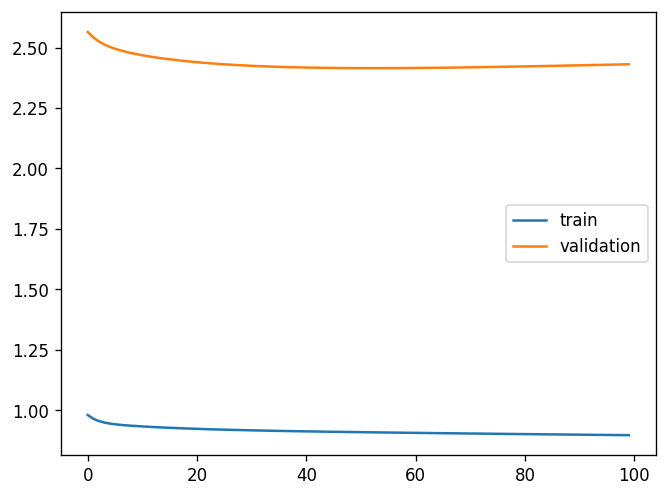

In [135]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=120)

ax.plot(np.arange(len(rnn.epoch_error)), rnn.epoch_error, label='train')
ax.plot(np.arange(len(rnn.val_error)), rnn.val_error, label='validation')
plt.legend()

## Look at some of the fitted values

In [149]:
means = scaler.mean_
standard_devs = np.sqrt(scaler.var_)

In [150]:
def get_predictions(loader, return_residuals = False):
    mse = nn.MSELoss(reduction="none")
    predictions = []
    residuals = []
    for idx, (x, y) in enumerate(loader):
        pred = rnn.predict(x)
        predictions.append(pred)
        
        res = pred-y.to(device)
        residuals.append(res)
        
    predictions_concat = torch.concat(predictions, dim=0).cpu().numpy()
    residuals_concat = torch.concat(residuals, dim=0).cpu().numpy()
    if return_residuals:
        return predictions_concat, residuals_concat
    else:
        return predictions_concat

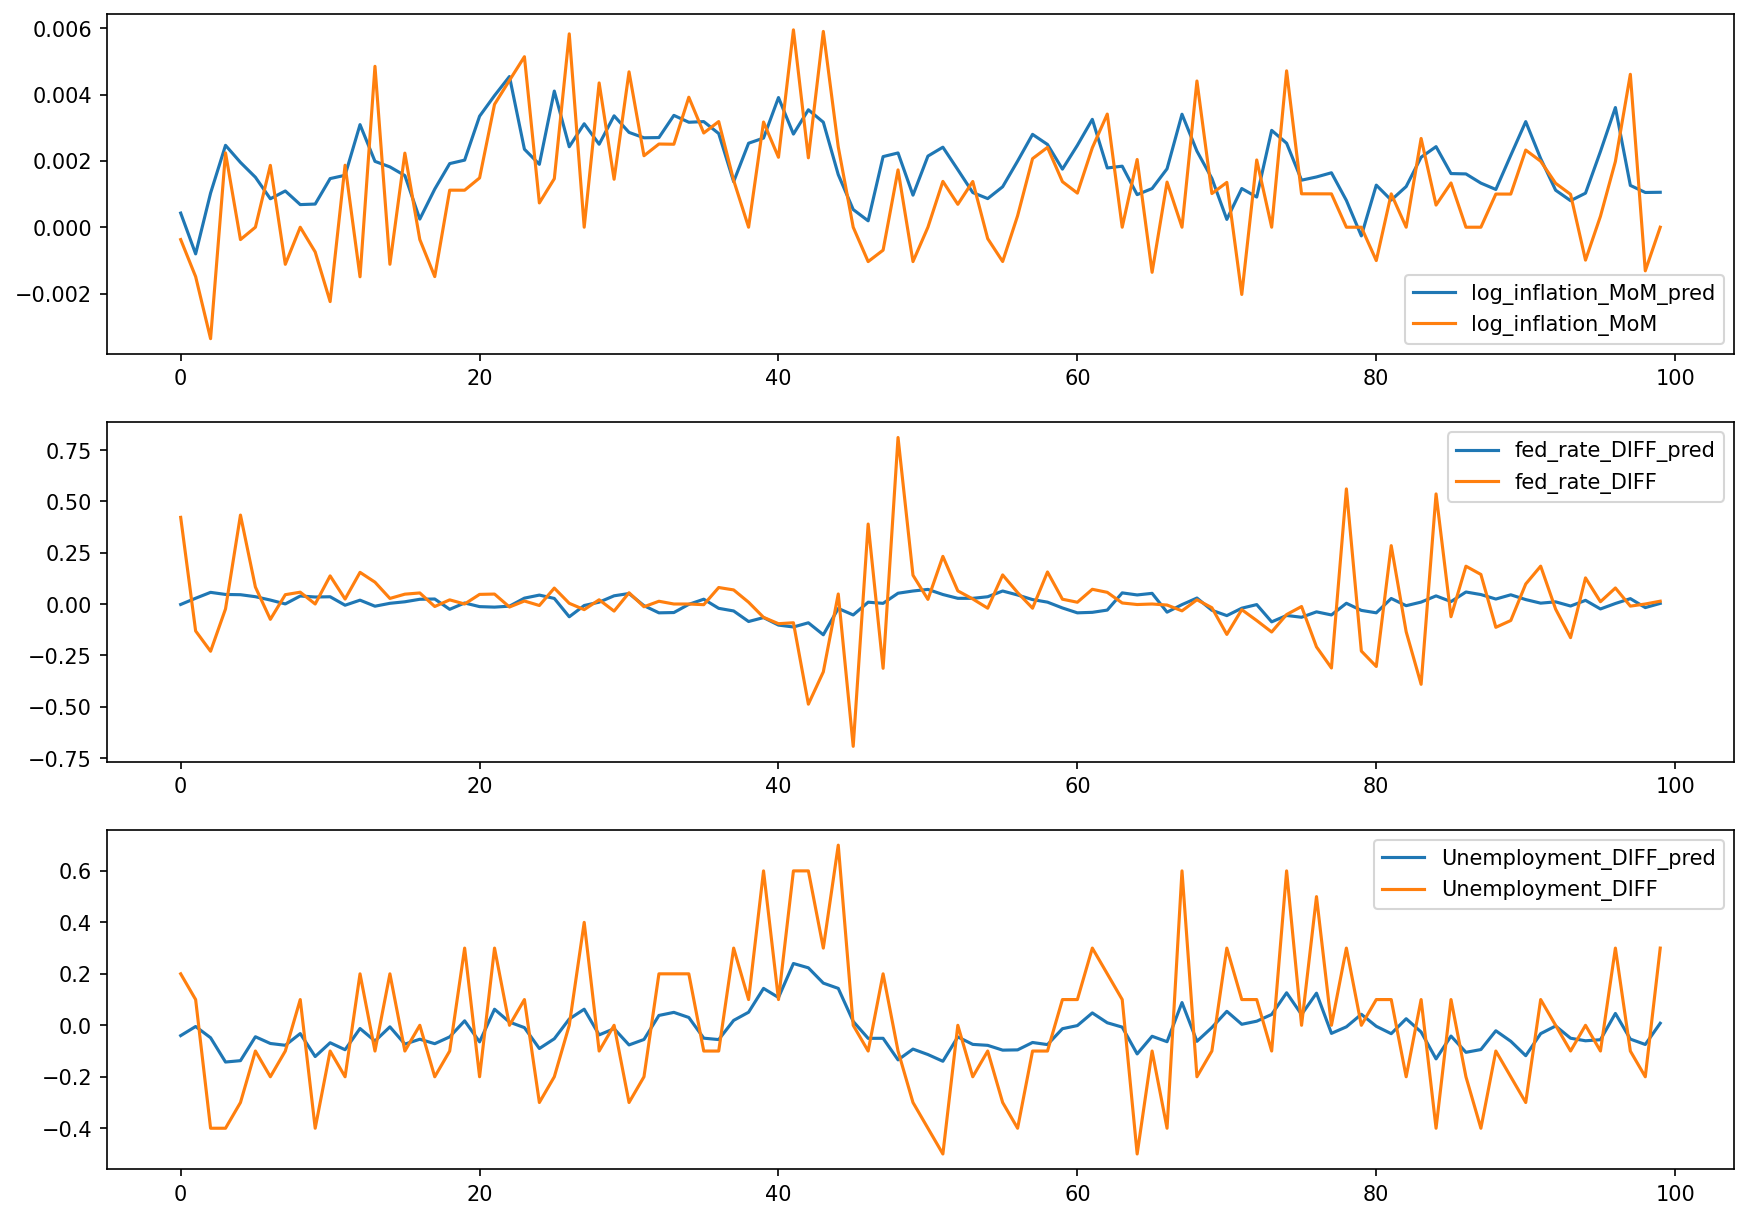

In [151]:

def plot_predictions(range_:list, loader, test=False):
    predictions = get_predictions(loader)

    # If we are testing we need to start the index at the cutoff for when we concatinate predictions 
    # with the actual values
    predictions_index = None if not test else np.arange(cutoff+seq_length+1, scaled_data_df.shape[0])

    predictions_df = pd.DataFrame(
        predictions, 
        columns = ["log_inflation_MoM_pred", "fed_rate_DIFF_pred", "Unemployment_DIFF_pred"], 
        index=predictions_index
    )

    fig, axs = plt.subplots(3, dpi=150, figsize=(14, 10))
    all_data=pd.concat([scaled_data_df, predictions_df], ignore_index=False, axis=1)


    (all_data[["log_inflation_MoM_pred", "log_inflation_MoM"]]*standard_devs[0] + means[0]).iloc[range_[0]:range_[1]].plot(ax=axs[0])
    (all_data[["fed_rate_DIFF_pred", "fed_rate_DIFF"]]*standard_devs[1] + means[1]).iloc[range_[0]:range_[1]].plot(ax=axs[1])
    (all_data[["Unemployment_DIFF_pred", "Unemployment_DIFF"]]*standard_devs[2] + means[2]).iloc[range_[0]:range_[1]].plot(ax=axs[2])

plot_predictions([0, 100], train_dataloader)

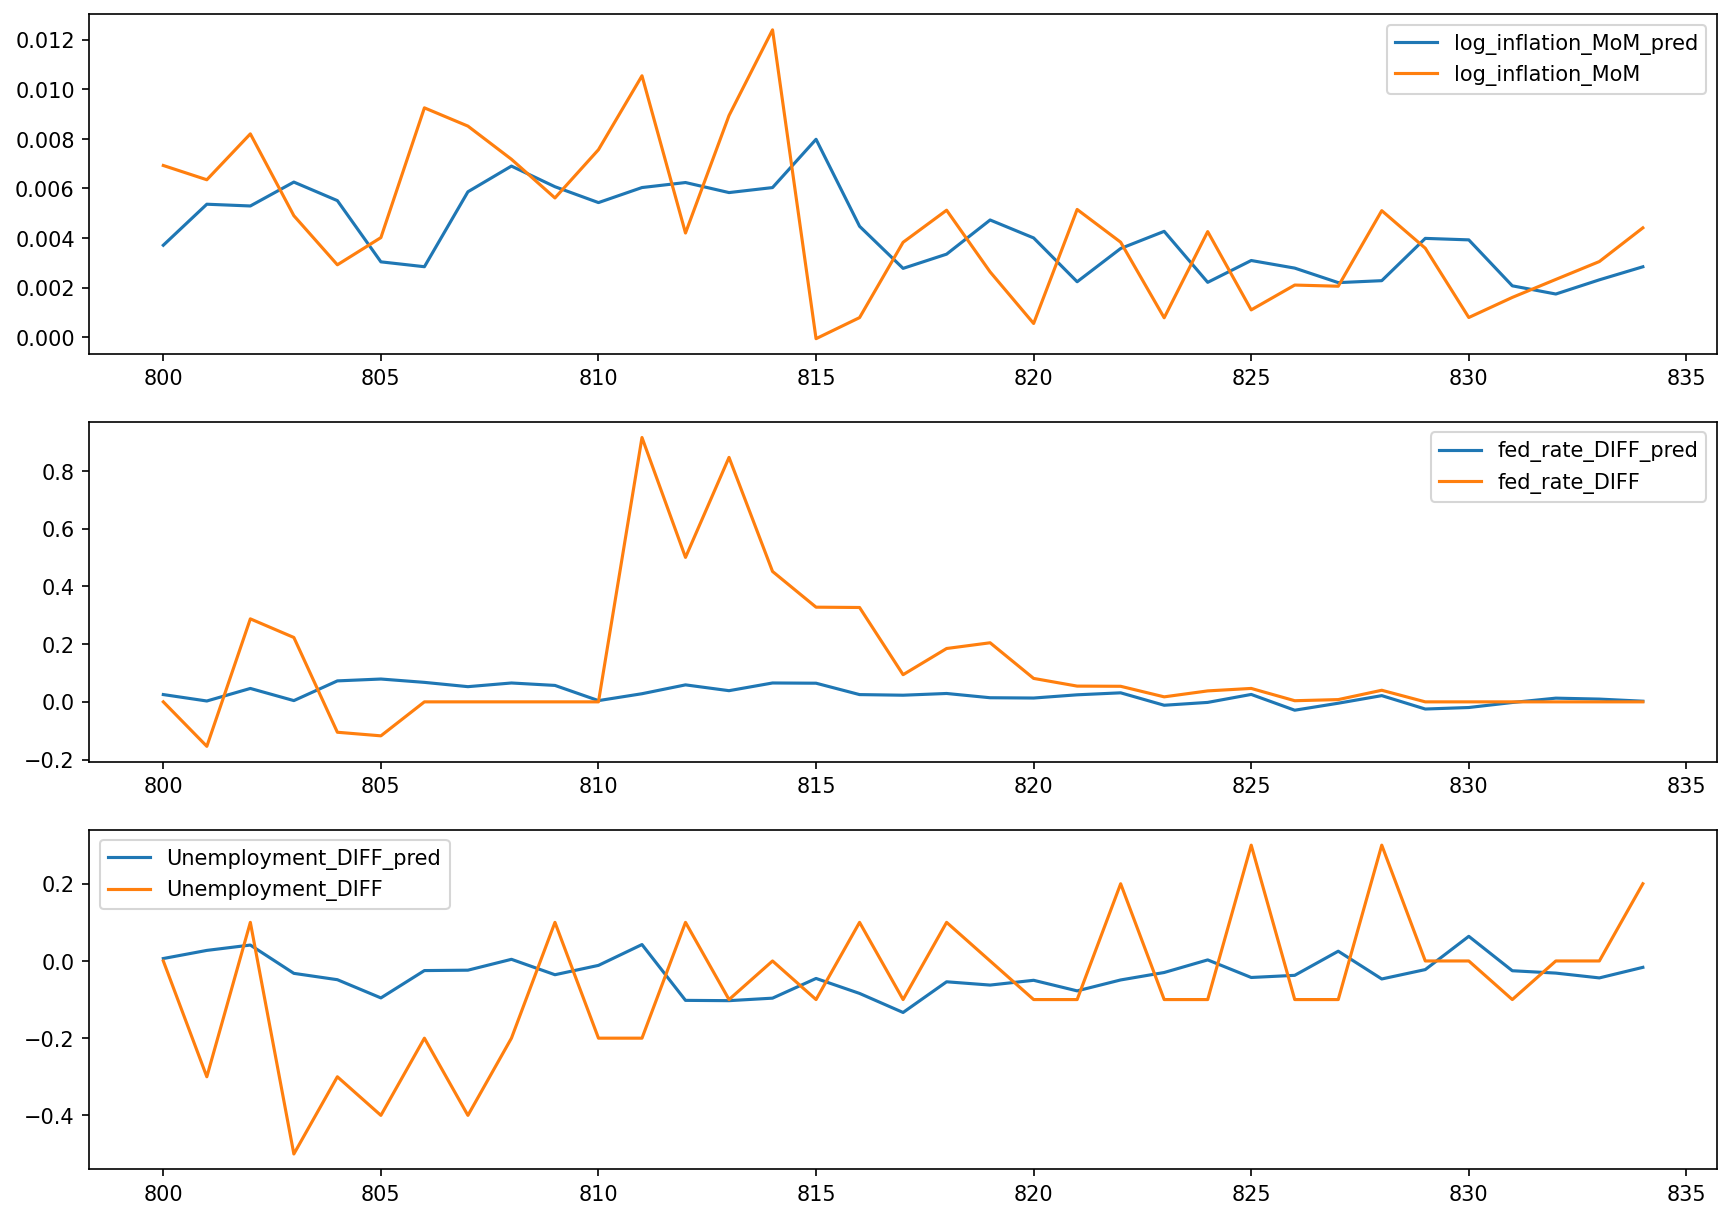

In [153]:
plot_predictions([800, data_diff.shape[0]], test_dataloader, test=True)

## Check that residuals are white noise

Text(0.5, 1.0, 'Unemployment_DIFF_pred Residuals')

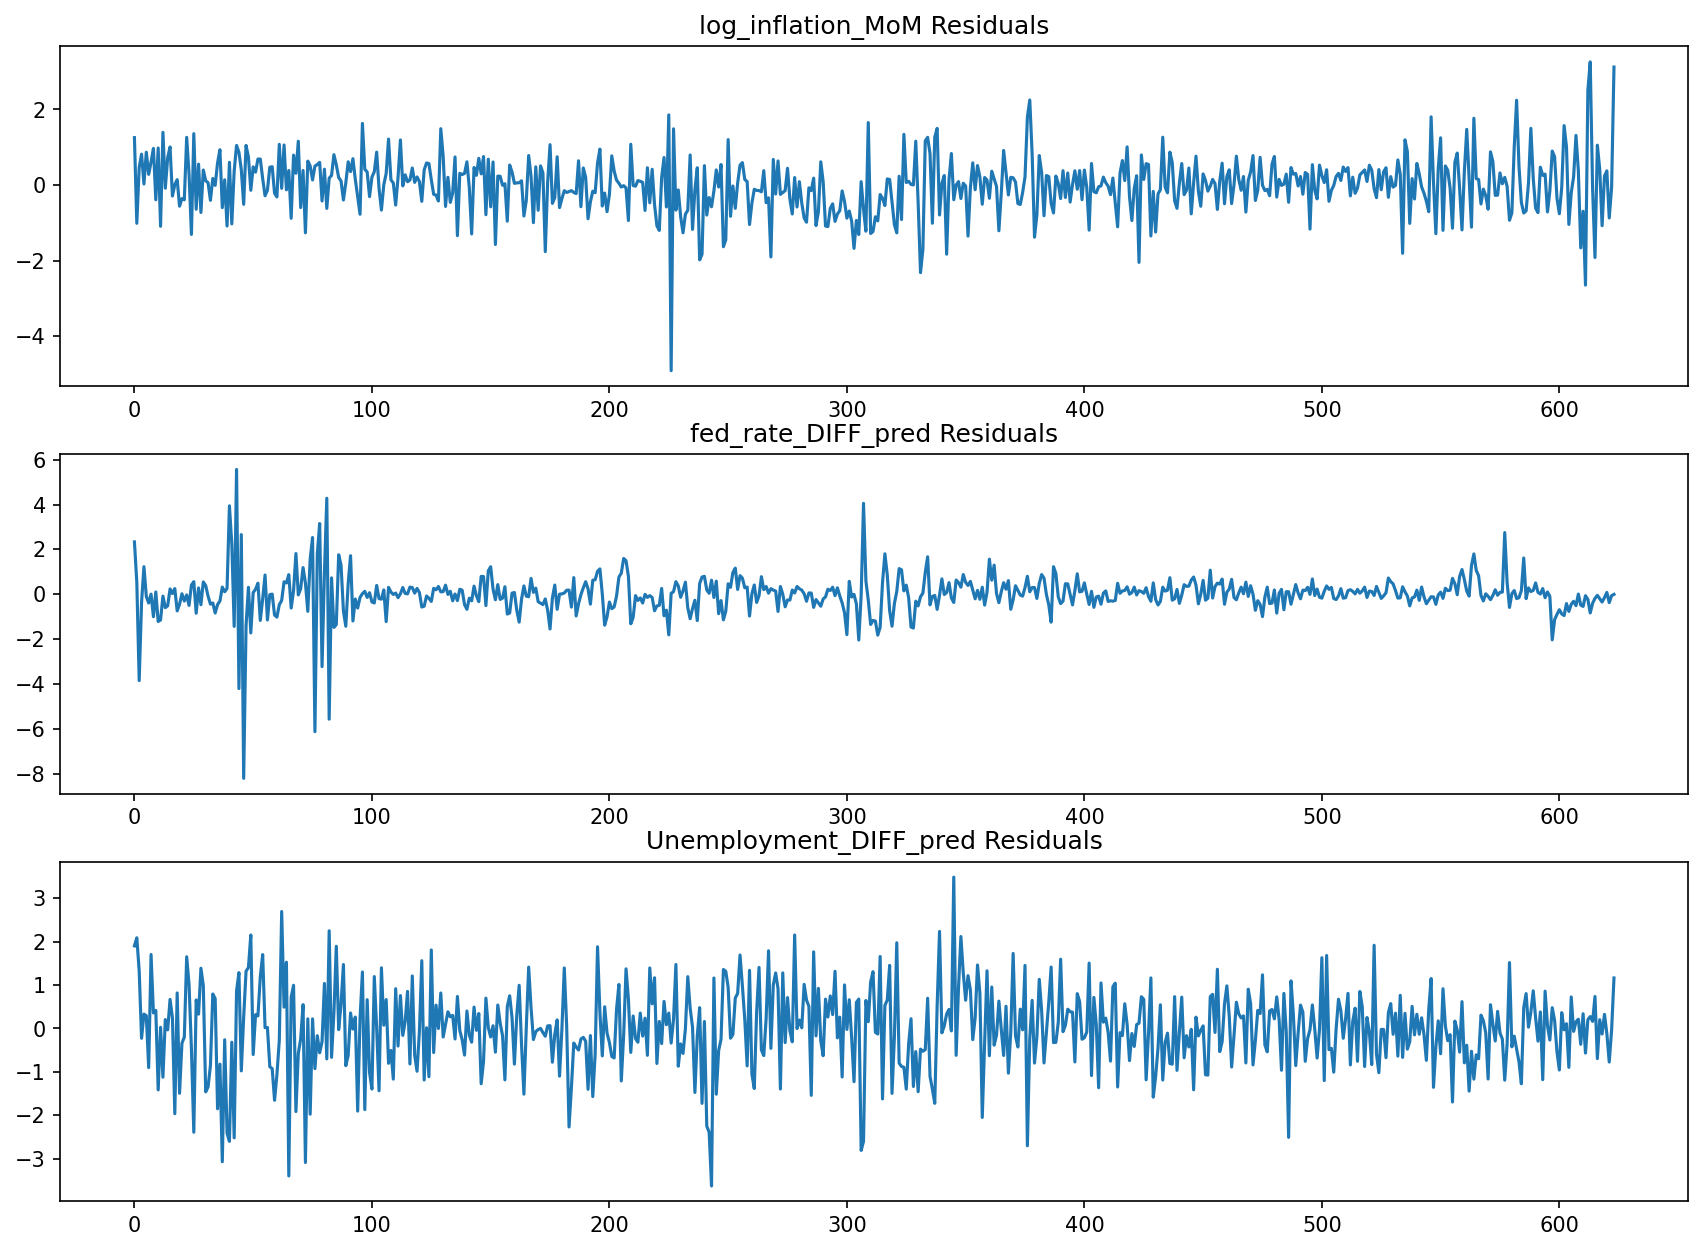

In [154]:
pred, res = get_predictions(train_dataloader,return_residuals=True)
residuals_df = pd.DataFrame(
        res, 
        columns = ["log_inflation_MoM_pred_res", "fed_rate_DIFF_pred_res", "Unemployment_DIFF_pred_res"]
    )

fig, axs = plt.subplots(3, dpi=150, figsize=(14, 10))

residuals_df["log_inflation_MoM_pred_res"].plot(ax=axs[0])
residuals_df["fed_rate_DIFF_pred_res"].plot(ax=axs[1])
residuals_df["Unemployment_DIFF_pred_res"].plot(ax=axs[2])
axs[0].set_title("log_inflation_MoM Residuals")
axs[1].set_title("fed_rate_DIFF_pred Residuals")
axs[2].set_title("Unemployment_DIFF_pred Residuals")

----

# LSTM With Pytorch

----

## Input gate, output gate, and forget gate
$I = \sigma(\mathbf{X}_t\mathbf{W}_{xi} + \mathbf{H}_{t-1}\mathbf{W}_{hi} + \mathbf{b}_{i}) \\ $ 
$O = \sigma(\mathbf{X}_t\mathbf{W}_{xo} + \mathbf{H}_{t-1}\mathbf{W}_{ho} + \mathbf{b}_{o}) \\ $
$F = \sigma(\mathbf{X}_t\mathbf{W}_{xf} + \mathbf{H}_{t-1}\mathbf{W}_{hf} + \mathbf{b}_{f})$

In [217]:
class Gate(nn.Module):
    def __init__(self, input_size, hidden_size,sigma = 0.01):
        super(Gate, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Params for input gate
        self.W_xi = nn.init.xavier_normal_(torch.randn(input_size, hidden_size))
        self.W_xi = nn.Parameter(self.W_xi)
        
        self.W_hi = nn.init.xavier_normal_(torch.randn(hidden_size, hidden_size))
        self.W_hi = nn.Parameter(self.W_hi)
        
        self.b_i = nn.init.xavier_normal_(torch.randn(1, hidden_size))
        self.b_i = nn.Parameter(self.b_i)
        
         
        self.sigmoid = nn.Sigmoid()
    
    
    def forward(self, X, old_state = None):
        if old_state is None:
            old_state = torch.zeros((X.shape[0], self.hidden_size),
                          device=X.device)    


        output = torch.matmul(X, self.W_xi) + torch.matmul(old_state, self.W_hi) + self.b_i

        return self.sigmoid(output)
    
            
        

In [223]:
I = Gate(3, 10).to(device)
O = Gate(3, 10).to(device)

with torch.no_grad():
    print(x[0].shape)
    print(I(x[0].to(device).float()))

torch.Size([2, 3])
tensor([[0.1624, 0.6387, 0.9524, 0.0661, 0.5123, 0.3485, 0.0752, 0.8344, 0.7171,
         0.6740],
        [0.8234, 0.6642, 0.4998, 0.6073, 0.5062, 0.7687, 0.5112, 0.5118, 0.6545,
         0.3540]], device='cuda:0')


In [219]:
class InputNode(nn.Module):
    def __init__(self, input_size, hidden_size, sigma = 0.01):
        super(InputNode, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Params for input gate
        self.W_xi = nn.init.xavier_normal_(torch.randn(input_size, hidden_size))
        self.W_xi = nn.Parameter(self.W_xi)
        
        self.W_hh = nn.init.xavier_normal_(torch.randn(self.hidden_size, self.hidden_size))
        self.W_hh = nn.Parameter(self.W_hh)
        
        self.b_i = nn.init.xavier_normal_(torch.randn(1, hidden_size))
        self.b_i = nn.Parameter(self.b_i)
        
         
        self.tanh = nn.Tanh()
    
    
    def forward(self, X, old_state = None):
        if old_state is None:
            old_state = torch.zeros((X.shape[0], self.hidden_size),
                          device=X.device)    

        yo = torch.matmul(old_state, self.W_hh)
        output = torch.matmul(X, self.W_xi) + torch.matmul(old_state, self.W_hh) + self.b_i
        return self.tanh(output)

In [220]:
in_ = InputNode(3, 10).to(device)
with torch.no_grad():
    print(x[0].shape)
    in_(x[0].to(device).float())

torch.Size([2, 3])


In [308]:
class MemoryCell(nn.Module):
    def __init__(self, input_size, hidden_size,sigma = 0.01):
        super(MemoryCell, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.I = Gate(self.input_size, self.hidden_size)
        self.F = Gate(self.input_size, self.hidden_size)
        self.O = Gate(self.input_size, self.hidden_size)
        
        self.input_node = InputNode(self.input_size, self.hidden_size)
        
        self.tanh = nn.Tanh()
    
    
    def forward(self, X, state = None, internal_state = None):
        if state is None:
            state = torch.zeros((X.shape[1], self.hidden_size),
                          device=X.device)    
        if internal_state is None:
            internal_state = torch.zeros((X.shape[1], self.hidden_size),
                          device=X.device)  
        outputs = []
        for x in X:
            I = self.I(x, state)
            F = self.F(x, state)
            O = self.O(x, state)
            input_ = self.input_node(x, state)

            internal_state = F*internal_state + I * input_
            state = O * self.tanh(internal_state)
            outputs.append(state[-1,:])
        return torch.cat(outputs, dim=-1).view(4, 1, self.hidden_size)

In [309]:
lstm = MemoryCell(3, 5)
with torch.no_grad():
    o=lstm(x.float())
    print(o)

tensor([[[-0.2068, -0.0930,  0.3656, -0.1722, -0.1810]],

        [[-0.4795, -0.3531,  0.0381, -0.0136,  0.2198]],

        [[-0.4121, -0.5174,  0.1164,  0.1578, -0.0099]],

        [[-0.0648, -0.5280,  0.1544,  0.0331, -0.0057]]])


In [306]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size,sigma = 0.01):
        super(LSTM, self).__init__()
        
        self.memory = MemoryCell(input_size, hidden_size)
        
        self.fc1 = nn.Linear(hidden_size, 3)
    
    def forward(self, X):
        x = self.memory(X)
        return self.fc1(x)
        
        

In [307]:
lstm = LSTM(3, 5)
with torch.no_grad():
    o=lstm(x.float())
    print(o)

tensor([[[ 0.1435, -0.1151,  0.3663]],

        [[ 0.0309, -0.0592,  0.3819]],

        [[ 0.0838, -0.0302,  0.3962]],

        [[ 0.3781, -0.0555,  0.5264]]])
